In [1]:
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import gc
import seaborn as sns

In [2]:
scoreDistribution={}

# IntAct


In [3]:
#Whole network
intAct_df = pd.read_csv('1 - input/intact-micluster.txt',sep='\t')
print(intAct_df.shape)
#Only Humans
intAct_df=intAct_df[(intAct_df['Taxid interactor A']=='taxid:9606(human)') & (intAct_df['Taxid interactor B']=='taxid:9606(human)')]
print(intAct_df.shape)

(743890, 15)
(342069, 15)


In [4]:
#The file has many reduntant collumns
intAct_df.head(1)

,#ID(s) interactor A,ID(s) interactor B,Alt. ID(s) interactor A,Alt. ID(s) interactor B,Alias(es) interactor A,Alias(es) interactor B,Interaction detection method(s),Publication 1st author(s),Publication Identifier(s),Taxid interactor A,Taxid interactor B,Interaction type(s),Source database(s),Interaction identifier(s),Confidence value(s)
0,intact:EBI-7121510,intact:EBI-2821539,uniprotkb:P49418,uniprotkb:O43426,psi-mi:amph_human|psi-mi:AMPH|uniprotkb:Q75MK5...,psi-mi:synj1_human|psi-mi:SYNJ1|uniprotkb:O434...,"psi-mi:""MI:0084""(phage display)|psi-mi:""MI:008...",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human),taxid:9606(human),"psi-mi:""MI:0407""(direct interaction)|psi-mi:""M...","psi-mi:""MI:0471""(MINT)",intact:EBI-7122727|intact:EBI-7122766|intact:E...,intact-miscore:0.558037


In [5]:
# to edge list with weight
edgeList=pd.DataFrame()
edgeList['Gene A']=intAct_df['Alias(es) interactor A'].str.split('|',expand=True)[1].str.replace('psi-mi:','')
edgeList['Gene B']=intAct_df['Alias(es) interactor B'].str.split('|',expand=True)[1].str.replace('psi-mi:','')
edgeList['weight']=intAct_df['Confidence value(s)'].str.replace('intact-miscore:','')

In [6]:
# Complete network
edgeList.dropna(inplace=True)
intAct_Complete=nx.from_pandas_edgelist(edgeList,source='Gene A',target='Gene B',edge_attr='weight')

In [7]:
# edge weight
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False
    
#add the weight as a edge attr in networkx    
i=0
for v1,v2 in intAct_Complete.edges():
    w=intAct_Complete.get_edge_data(v1, v2)['weight']
    
    if(not isfloat(w)):
        value=w.split('|')[-1]
        nx.set_edge_attributes(intAct_Complete, {(v1, v2): {"weight": value}})
        
weights=[]
for v1,v2 in intAct_Complete.edges():
    w=intAct_Complete.get_edge_data(v1, v2)['weight']
    w=round(float(w),2)
    nx.set_edge_attributes(intAct_Complete, {(v1, v2): {"weight": w}})
    nx.set_edge_attributes(intAct_Complete, {(v1, v2): {"weightInverse": w**-1}})
    weights.append(w)
scoreDistribution['IntAct Complete']=weights

In [8]:
intAct_SignificantEdges=nx.Graph()
for v1,v2 in intAct_Complete.edges():
    w=intAct_Complete.get_edge_data(v1, v2)['weight']
    wi=intAct_Complete.get_edge_data(v1, v2)['weightInverse']
    wi=round(float(wi),2)
    if(w>=0.5):
        intAct_SignificantEdges.add_edge(v1, v2, weight=w,weightInverse=wi)
print(intAct_Complete,' | ',intAct_SignificantEdges)

Graph with 20807 nodes and 328288 edges  |  Graph with 13437 nodes and 91701 edges


In [9]:
nx.write_edgelist(intAct_Complete,'1 - output\intAct_Complete.edgelist',delimiter='\t')

In [10]:
weights=[]
for v1,v2 in intAct_SignificantEdges.edges():
    w=intAct_SignificantEdges.get_edge_data(v1, v2)['weight']
    weights.append(w)
scoreDistribution['IntAct Significant']=weights

In [11]:
nx.write_edgelist(intAct_SignificantEdges,'1 - output\intAct_Significant.edgelist',delimiter='\t')

In [12]:
del intAct_df
del edgeList
del intAct_Complete
del intAct_SignificantEdges
gc.collect()

34358

# STRING



In [13]:
string_df = pd.read_csv('1 - input/9606.protein.links.v11.5.txt',sep=' ',)
string_df.head()

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000379496,155
1,9606.ENSP00000000233,9606.ENSP00000314067,197
2,9606.ENSP00000000233,9606.ENSP00000263116,222
3,9606.ENSP00000000233,9606.ENSP00000361263,181
4,9606.ENSP00000000233,9606.ENSP00000409666,270


In [14]:
stringInfo_df = pd.read_csv('1 - input/9606.protein.info.v11.5.txt',sep='\t')
stringInfo_df.head()

,#string_protein_id,preferred_name,protein_size,annotation
0,9606.ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,9606.ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,9606.ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...
3,9606.ENSP00000001146,CYP26B1,512,Cytochrome P450 26B1; Involved in the metaboli...
4,9606.ENSP00000002125,NDUFAF7,441,"Protein arginine methyltransferase NDUFAF7, mi..."


In [15]:
STRING_complete = nx.from_pandas_edgelist(string_df,source='protein1',target='protein2',edge_attr='combined_score')
#update de name 
nx.relabel_nodes(STRING_complete,
                 {a[0]:a[1] for a in stringInfo_df[['#string_protein_id','preferred_name']].to_numpy()}
                 ,copy=False);

In [16]:
STRING_SignificantEdges=nx.Graph()
for v1,v2 in STRING_complete.edges():
    w=STRING_complete.get_edge_data(v1, v2)['combined_score']
    if(w>=700):
        wPerc=w/1000
        wi=wPerc**-1
        wi=round(wi,2)
        STRING_SignificantEdges.add_edge(v1, v2, weight=wPerc,weightInverse=wi)
print(STRING_complete,' | ',STRING_SignificantEdges)

Graph with 19382 nodes and 5968680 edges  |  Graph with 16812 nodes and 252953 edges


In [17]:
weights=[]
for v1,v2 in STRING_complete.edges():
    w=STRING_complete.get_edge_data(v1, v2)['combined_score']
    weights.append(w)
scoreDistribution['STRING Complete']=weights

weights=[]
for v1,v2 in STRING_SignificantEdges.edges():
    w=STRING_SignificantEdges.get_edge_data(v1, v2)['weight']
    weights.append(w)
scoreDistribution['STRING Significant']=weights

In [18]:
nx.write_edgelist(STRING_SignificantEdges,'1 - output\STRING_Significant.edgelist',delimiter='\t')

In [19]:
del string_df
del stringInfo_df
del STRING_complete
del STRING_SignificantEdges
gc.collect()

36275

# HINT

In [20]:
HINT_df = pd.read_csv('1 - input/HINT.txt',sep='\t')
print(HINT_df.shape)

(119526, 9)


In [21]:
HINT_Complete=nx.from_pandas_edgelist(HINT_df,source='Gene_A',target='Gene_B')
print(HINT_Complete)
nx.write_edgelist(HINT_Complete,'1 - output\HINT_Complete.edgelist',delimiter='\t')

Graph with 15357 nodes and 119494 edges


In [22]:
del HINT_df
del HINT_Complete
gc.collect()

15386

# Reactome FI

In [23]:
Reactome_df = pd.read_csv('1 - input/Reactome2021.txt',sep='\t')
Reactome_df['weight']=Reactome_df['Score']
scoreDistribution['Reactome Complete']=sorted(Reactome_df['Score'])
Reactome_df['weightInverse']=round(Reactome_df['weight']**-1,2)

In [24]:
Reactome_df['weightInverse']

0         1.03
1         1.00
2         1.00
3         1.00
4         1.00
          ... 
257624    1.03
257625    1.00
257626    1.00
257627    1.00
257628    1.03
Name: weightInverse, Length: 257629, dtype: float64

In [25]:
ReactomeComplete = nx.from_pandas_edgelist(Reactome_df,source='Gene1',target='Gene2',edge_attr=['weight','weightInverse'])
print(ReactomeComplete)

Graph with 13953 nodes and 257629 edges


In [26]:
nx.write_edgelist(ReactomeComplete,'1 - output\Reactome_Complete.edgelist',delimiter='\t')

In [27]:
Reactome_df=Reactome_df[Reactome_df['Score']>=0.7]
scoreDistribution['Reactome Significant']=sorted(Reactome_df['Score'])
Reactome = nx.from_pandas_edgelist(Reactome_df,source='Gene1',target='Gene2',edge_attr=['weight','weightInverse'])
print(Reactome)

Graph with 12184 nodes and 228699 edges


In [28]:
nx.write_edgelist(Reactome,'1 - output\Reactome_Significant.edgelist',delimiter='\t')

# Score Distribution

In [29]:
scoreDistribution.keys()

dict_keys(['IntAct Complete', 'IntAct Significant', 'STRING Complete', 'STRING Significant', 'Reactome Complete', 'Reactome Significant'])

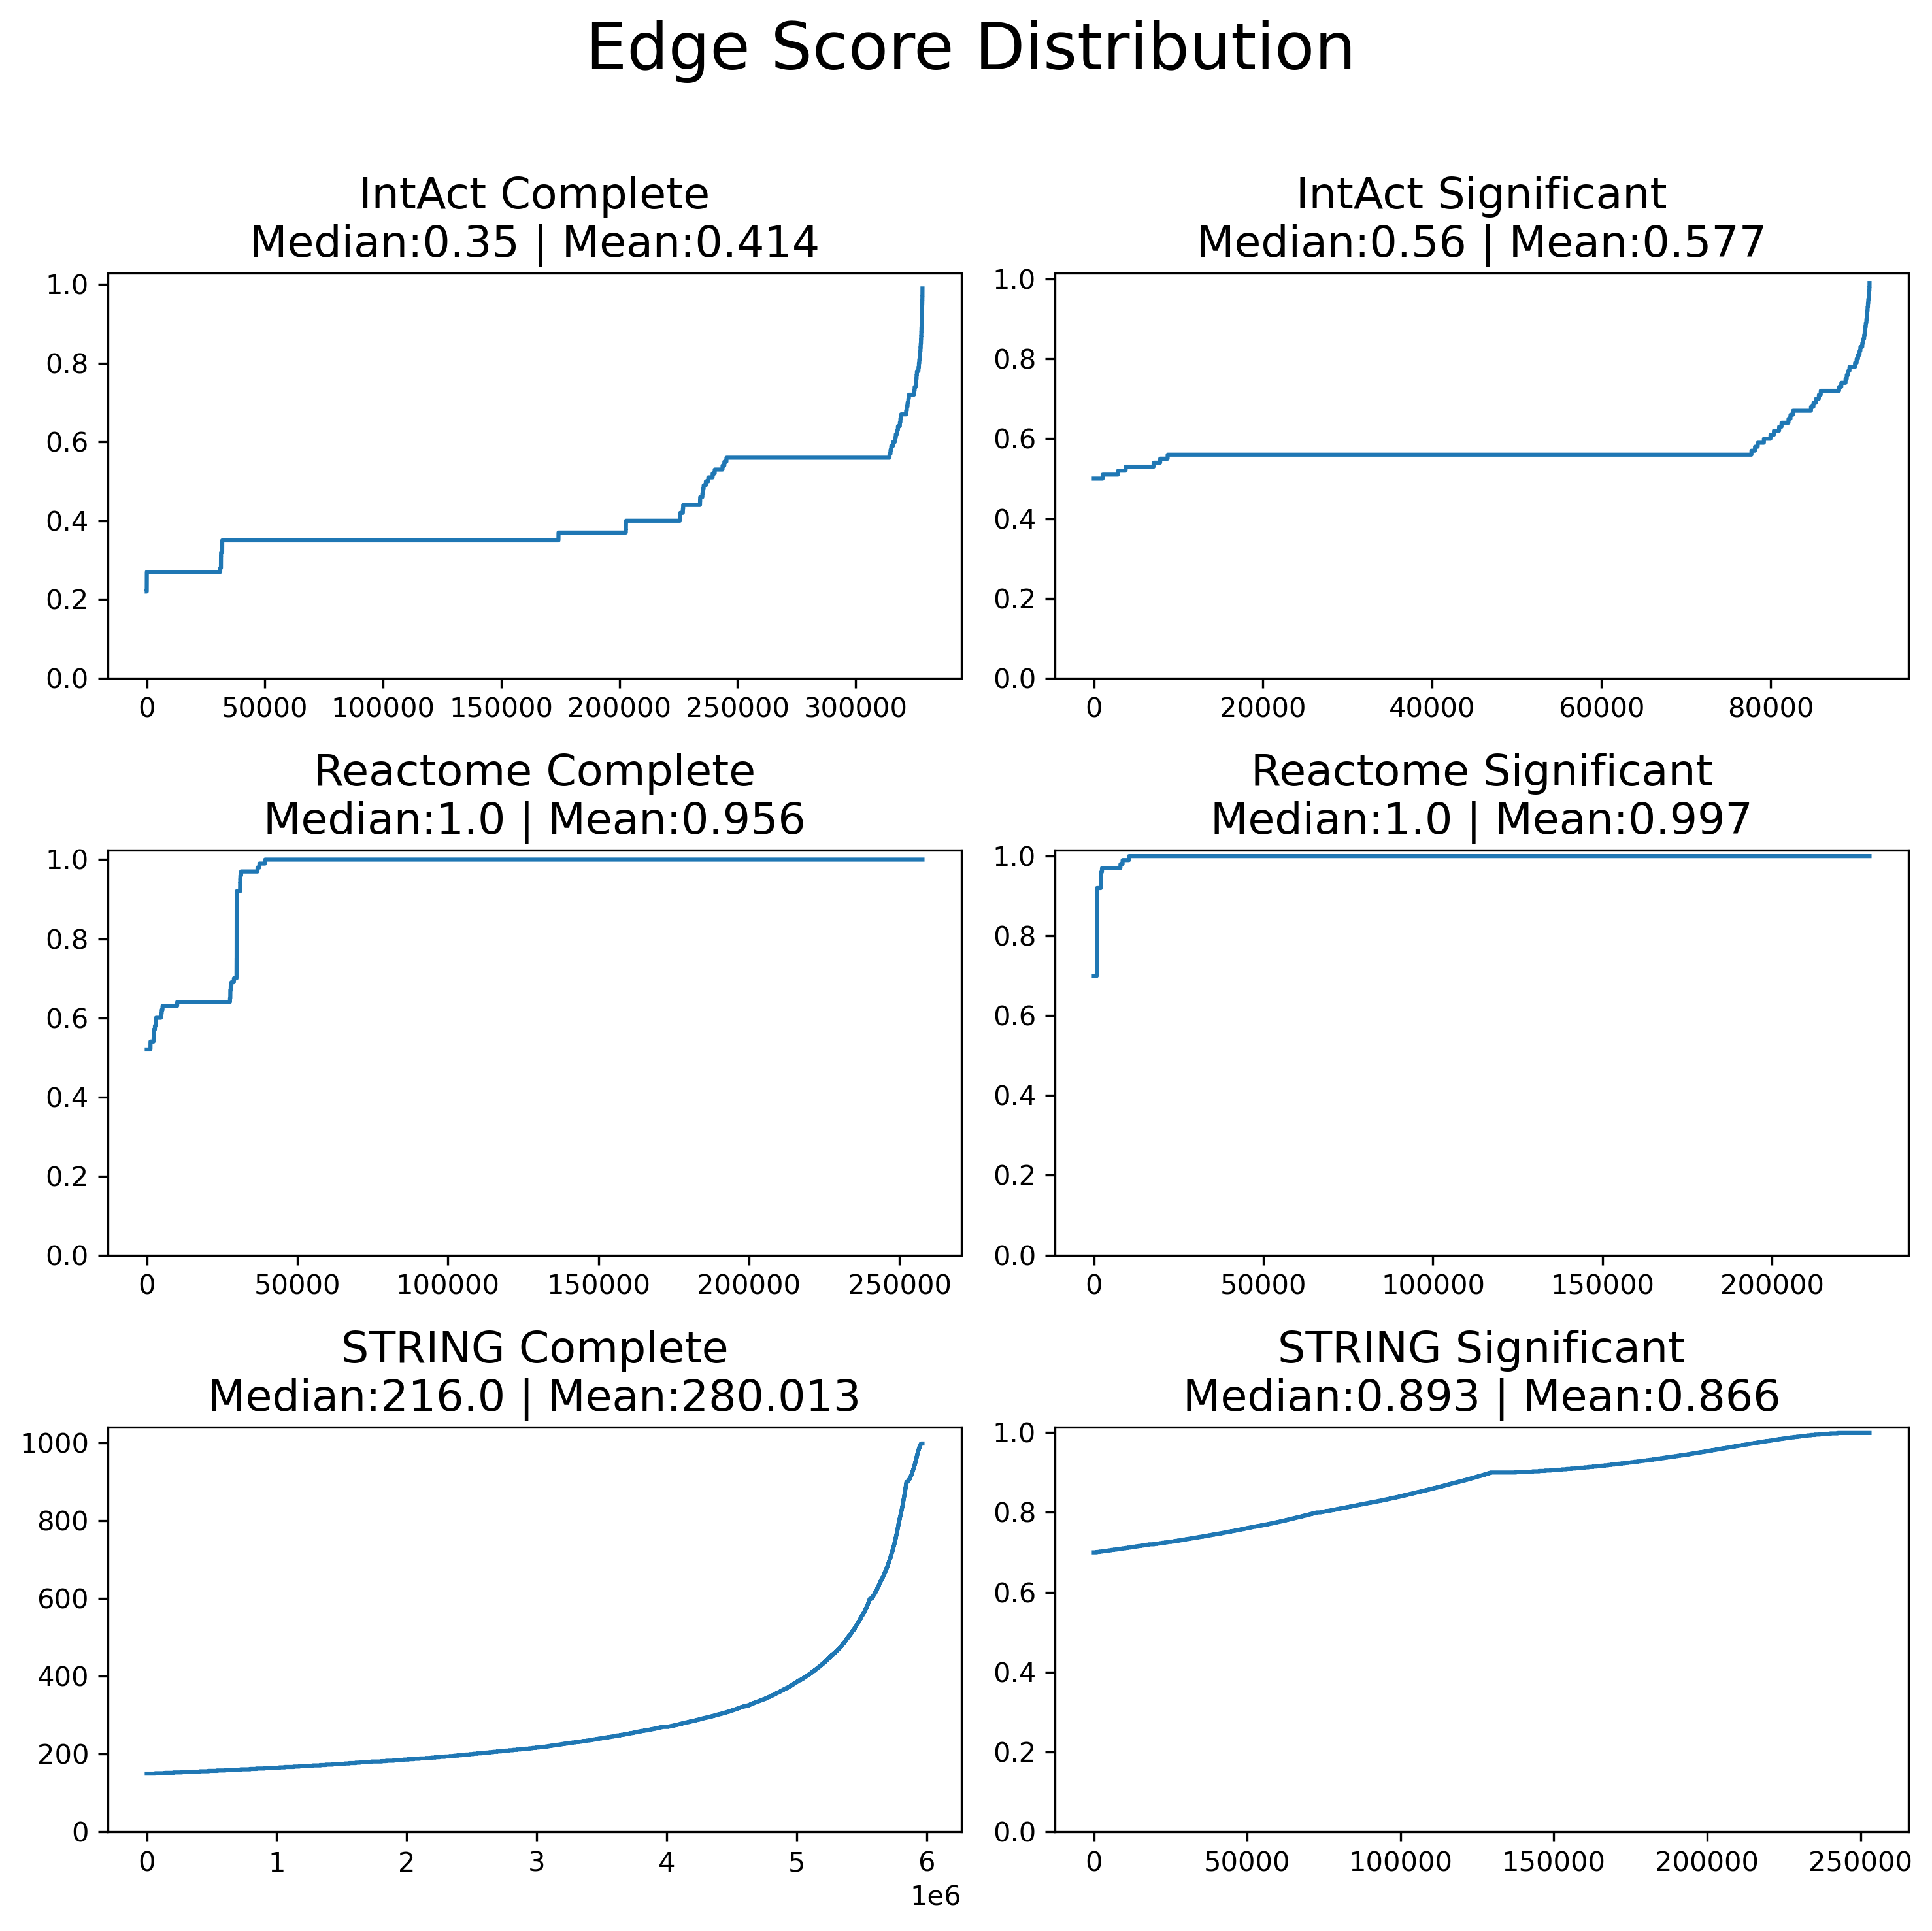

In [30]:
plt.figure(figsize=(10,10),dpi=300) 
i=1
for name in sorted(scoreDistribution.keys()):
    plt.subplot(3,2,i)
    i=i+1
    weights=scoreDistribution[name]
    median=np.median(weights)
    mean = round(np.mean(weights),3)
    plt.plot(sorted(weights))
    plt.title(name+'\nMedian:'+str(median)+' | Mean:'+str(mean),fontsize=16)
    if name !='STRING Complete':
        plt.yticks(np.arange(0, 1.2, step=0.2))
    else:
        plt.yticks(np.arange(0, 1200, step=200))
    
plt.suptitle('Edge Score Distribution\n',fontsize=24)
plt.tight_layout()
plt.savefig("1 - output/edgeScoreDistribution.pdf", format='pdf', dpi=1000,facecolor='white')
plt.show()

In [31]:
scoreDistribution['STRING Complete']=[x/1000 for x in scoreDistribution['STRING Complete']]

In [32]:
namesWithInfo=[]
for name in scoreDistribution.keys():
    weights=scoreDistribution[name]
    median=np.median(weights)
    mean = round(np.mean(weights),3)
    namesWithInfo.append(name+'\nx͂:'+str(median)+' x̅:'+str(mean))

In [33]:
namesWithInfo

['IntAct Complete\nx͂:0.35 x̅:0.414',
 'IntAct Significant\nx͂:0.56 x̅:0.577',
 'STRING Complete\nx͂:0.216 x̅:0.28',
 'STRING Significant\nx͂:0.893 x̅:0.866',
 'Reactome Complete\nx͂:1.0 x̅:0.956',
 'Reactome Significant\nx͂:1.0 x̅:0.997']

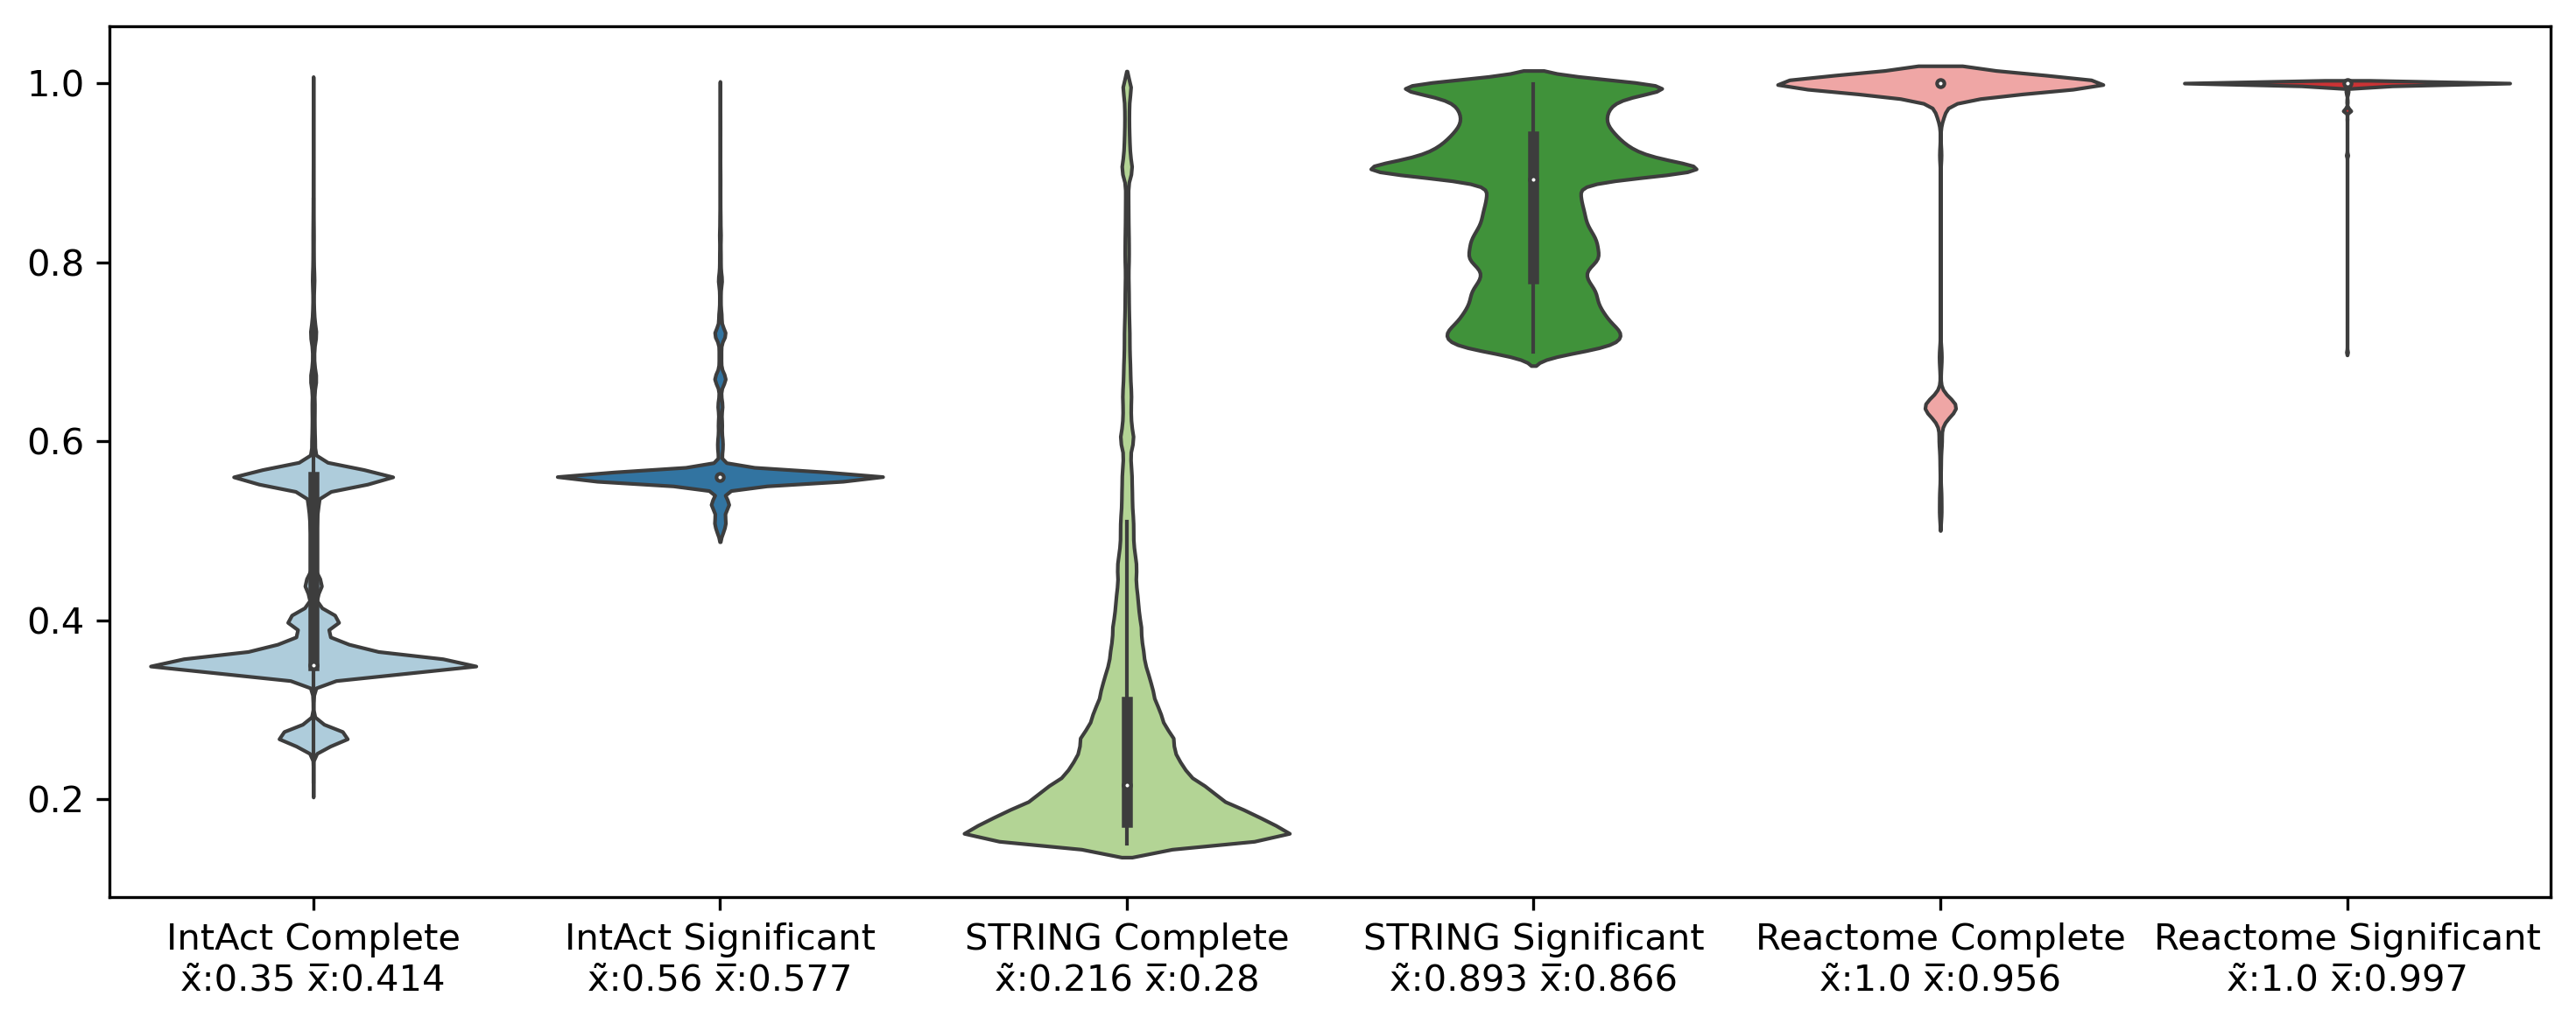

In [34]:
plt.figure(figsize=(10,4),dpi=300)
sns.violinplot(data=[values for name, values in scoreDistribution.items()],scale='width',linewidth = 1,palette='Paired')
plt.xticks(ticks=np.arange(6), labels=namesWithInfo)
plt.tight_layout()
plt.savefig("1 - output/edgeScoreDistribution_ViolinPlot.pdf", format='pdf', dpi=1000,facecolor='white')
plt.show()